# Imports

In [1]:
import os
import PIL
import fastai
from fastai.vision import *
from tqdm import tqdm_notebook
from datetime import datetime

random.seed(datetime.now())

# Source Minimaps

## Stats

In [6]:
data_dir = "./locator/data/"
red_verified_dir =  "./locator/data/red-verified/"
not_red_verified_dir =  "./locator/data/not-red-verified/"
player_verified_dir =  "./locator/data/player-verified/"
player_unverified_dir =  "./locator/data/player-unverified/"
terrain_verified_dir =  "./locator/data/terrain-verified/"
terrain_unverified_dir =  "./locator/data/terrain-unverified/"

l = len(os.listdir(red_verified_dir))
print("Red players: " + str(l))
l = len(os.listdir(not_red_verified_dir))
print("Not red players: " + str(l))
l = len(os.listdir(player_verified_dir))
print("Verified players: " + str(l))
l = len(os.listdir(player_unverified_dir))
print("Unverified players: " + str(l))
l = len(os.listdir(terrain_verified_dir))
print("Verified terrain: " + str(l))
l = len(os.listdir(terrain_unverified_dir))
print("Unverified terrain: " + str(l))

Verified players: 1333
Unverified players: 9259
Verified terrain: 3901
Unverified terrain: 171581


## Sort

In [4]:
import tkinter as tk
import csv
import random
from PIL import Image, ImageDraw, ImageTk

grid_size = 5
grid_lines = int(150 / grid_size)
source_dir = terrain_unverified_dir


def next_img(dest):
    root.moved_images.append(dest)
    root.img_index += 1
    draw_map()
    img = root.image_list[root.img_index]


def player():
    img = root.image_list[root.img_index]
    src = source_dir + img
    dest = player_verified_dir + img
    os.rename(src, dest)
    next_img(dest)

def terrain():
    img = root.image_list[root.img_index]
    src = source_dir + img
    dest = terrain_verified_dir + img
    os.rename(src, dest)
    next_img(dest)


def undo():
    img = root.moved_images.pop()
    name = img.split("/")[-1]
    root.img_index -= 1
    os.rename(img, f"{source_dir}/{name}")
    draw_map()


def draw_grid(draw):
    i = 12
    j = 18
    fill = (0, 255, 0, 198)
    draw.line([i, i, i, j], fill=fill)
    draw.line([i, j, j, j], fill=fill)
    draw.line([j, j, j, i], fill=fill)
    draw.line([j, i, i, i], fill=fill)


def draw_map():
    img = Image.open(f"{source_dir}{root.image_list[root.img_index]}").convert('RGBA')
    overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw)
    out = Image.alpha_composite(img, overlay)
    print(out)
    root.photo = ImageTk.PhotoImage(out)
    map_label.configure(image=root.photo)


root = tk.Tk()
images = os.listdir(source_dir)
random.shuffle(images)
root.image_list = images
root.img_index = 0
root.moved_images = []

map_label = tk.Label(root)
map_label.pack()
draw_map()

terrain_btn = tk.Button(root, text="Terrain", command=terrain, bg="brown", height = 3, width = 30)
terrain_btn.pack()
player_btn = tk.Button(root, text="Player", command=player, bg="blue", height = 3, width = 30)
player_btn.pack()


undo_btn = tk.Button(root, text="Undo", command=undo, height = 3, width = 30)
undo_btn.pack()

root.mainloop()

<PIL.Image.Image image mode=RGBA size=30x30 at 0x7FD2229AE990>


# Review Locator Model

## Overlay Functions

In [30]:
model_path = "./locator/data/models/"
learn = load_learner(model_path, "locator.pth")

grid_size = 5

def empty_dir(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)


def draw_grid(draw, labels):
    fill = (0, 255, 255, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        if l[2] == "terrain":
            continue
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)


def draw_preds(filename, grids):
    img = PIL.Image.open(filename).convert("RGBA")

    overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_grid(draw, grids)
    out = PIL.Image.alpha_composite(img, overlay).convert("RGBA")
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img);
    ax[1].imshow(out);
    return img, out
#     imshow(np.asarray(out))


def get_predictions(learner, predictions):
    # Predict the grid image types
    tmp_dir = data_dir + "tmp"
    test = ImageList.from_folder(tmp_dir)
    learner.data.add_test(test)
    preds = learner.get_preds(ds_type=DatasetType.Test)
    num_preds = len(preds)
    z = 0

    # Identify the grids which are player squares
    for i in range(len(preds[0])):
        max_index = 0
        max_score = 0
        for p in range(len(preds[0][i])):
            if preds[0][i][p] > max_score:
                max_index = p
                max_score = preds[0][i][p]
                
        category = str(learn.data.classes[max_index])
        if category == "terrain":
            continue
        img = test.items[i]
        fname = img.stem
        num = int(fname.split("-")[1])
        name = fname.split("-")[0]
        x = num//1000
        y = num % 1000
        predictions[name].append((x, y, category))

    empty_dir(tmp_dir)
    return predictions


def get_grids(learner, filenames):
    print("locating player positions...")
    padding = 10
    num_files = len(filenames)
    predictions = {}
    # Split the image into grids and save the components to the tmp directory.
    tmp_dir = data_dir+"tmp"
    empty_dir(tmp_dir)
    z = 0
    numfiles = len(filenames)
    for l in range(numfiles):
        f = filenames[l]
        if not ".png" in f:
            continue
        im = PIL.Image.open(f)
        imgwidth, imgheight = im.size
        base = os.path.basename(f)
        fname = os.path.splitext(base)[0]
        predictions[fname] = []
        for i in range(0, imgheight, grid_size):
            for j in range(0, imgwidth, grid_size):
                box = (j-14, i-14, j + grid_size +
                       16, i + grid_size + 16)
                a = im.crop(box)
                a.save(data_dir+f"/tmp/{fname}-{j*1000//grid_size+i//grid_size}.png")

        if z % 1000 == 0:
            predictions = get_predictions(learner, predictions)
        z += 1

    if len(os.listdir(tmp_dir)) > 0:
        predictions = get_predictions(learner, predictions)

    return predictions

## Generate Review Overlays

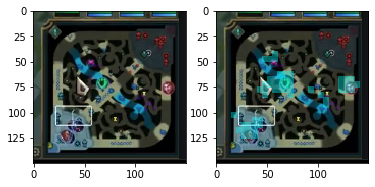

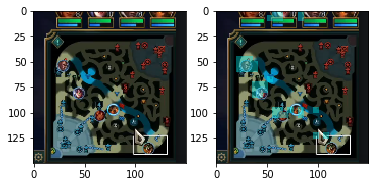

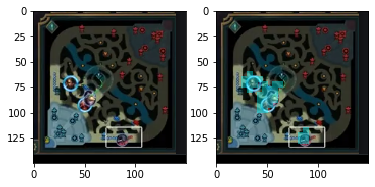

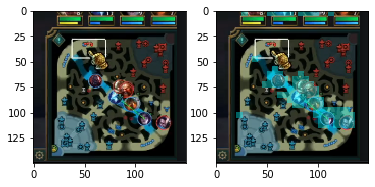

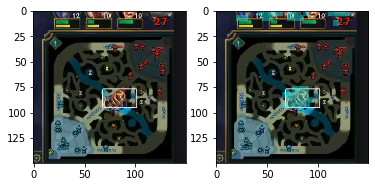

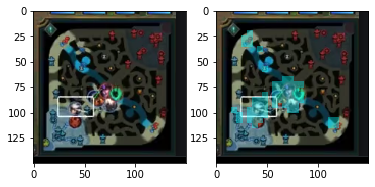

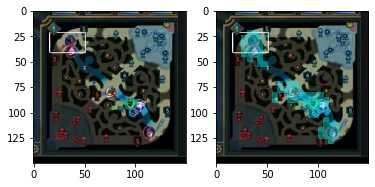

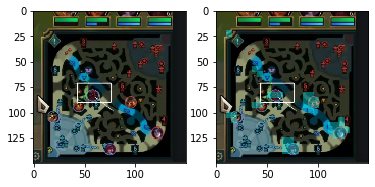

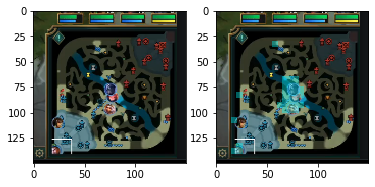

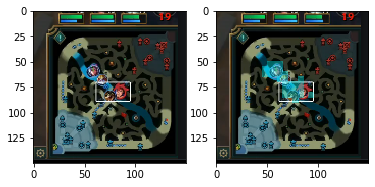

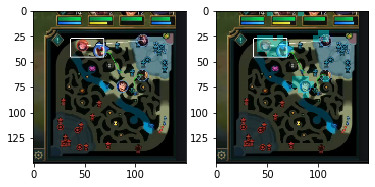

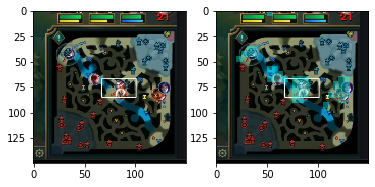

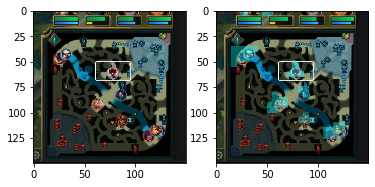

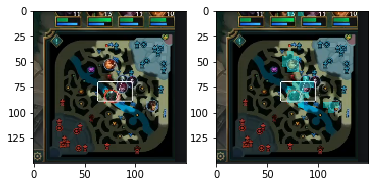

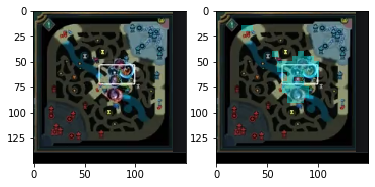

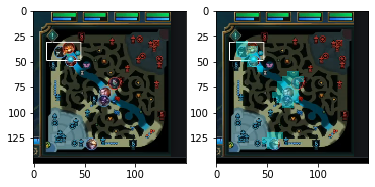

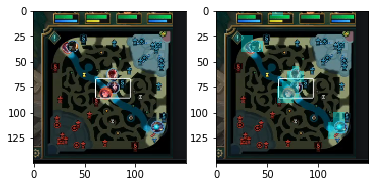

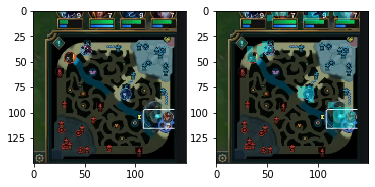

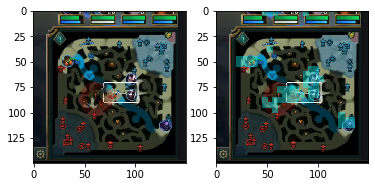

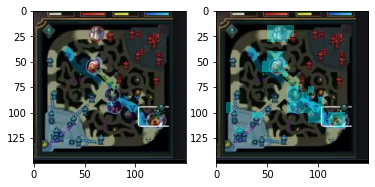

In [31]:
for i in range(0, 20):
    game = random.choice(os.listdir("games"))
    screenshot = random.choice(os.listdir(f"games/{game}/full/"))
    filenames = [
        f"games/{game}/full/{screenshot}"]
    grids = get_grids(learn, filenames)
    base = os.path.basename(filenames[0])
    fname = os.path.splitext(base)[0]
    img, out = draw_preds(filenames[0], grids[fname])
    img.save(data_dir+f"review/actual/{fname}.png")
    out.save(data_dir+f"review/composite/{fname}.png")

## Review

In [32]:
import tkinter as tk
import csv
import random
from PIL import Image, ImageDraw, ImageTk

grid_size = 5

def done_review():
    src_img = Image.open(f"{actual_dir}{root.image_list[root.img_index]}").convert('RGBA')
    unique_labels = set(root.labels)
    for l in unique_labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        img = src_img.crop((x-14, y-14, x+16, y+16)).save(f"{dst_dir}{int(l[0])}_{int(l[1])}_{root.image_list[root.img_index]}")
    os.remove(f"{source_dir}{root.image_list[root.img_index]}")
    os.remove(f"{actual_dir}{root.image_list[root.img_index]}")
    root.img_index += 1
    if root.img_index >= len(root.image_list):
        root.destroy()
    else:
        root.labels = []
        draw_map()
        
def undo_review():
    root.labels.pop()
    draw_map()

def click_image(event):
    x, y = event.x, event.y
    root.labels.append(((x-grid_size/2)//grid_size,(y-grid_size/2)//grid_size))
    draw_map()
    
def draw_select_grid(draw, labels):
    fill = (255, 0, 0, 96)
    for l in labels:
        x = l[0] * grid_size
        y = l[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
def draw_map():
    img = Image.open(f"{source_dir}{root.image_list[root.img_index]}").convert('RGBA')
    overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    draw_select_grid(draw, root.labels)
    out = Image.alpha_composite(img, overlay)
    root.photo = ImageTk.PhotoImage(out)
    map_label.configure(image=root.photo)
    
def next_img(dest):
    root.moved_images.append(dest)
    root.img_index += 1
    draw_map()
    img = root.image_list[root.img_index]

labels = []
source_dir = "./locator/data/review/composite/"
actual_dir = "./locator/data/review/actual/"
dst_dir = "./locator/data/review/terrain/"
root = tk.Tk()
root.labels = labels

images = os.listdir(source_dir)
images = [im for im in images if ".png" in im]
random.shuffle(images)
root.image_list = images
root.img_index = 0
root.moved_images = []

map_label = tk.Label(root)
map_label.pack()
draw_map()

ok_btn = tk.Button(root, text="Done Review", command=done_review, bg="brown", height = 3, width = 30)
ok_btn.pack()

undo_btn = tk.Button(root, text="Undo", command=undo_review, height = 3, width = 30)
undo_btn.pack()

map_label.bind("<Button 1>",click_image)

root.mainloop()